In [1]:
# Before running this please change the RUNTIME to GPU (Runtime -> Change runtime type -> set hardware accelerator as GPU)
# Mount our google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
### **Cell 1: Import Libraries and Setup**
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn
import pandas as pd
import os

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
### **Cell 2: Dataset Class Definition**
class VideoDataset(Dataset):
    def __init__(self, video_names, labels, sequence_length=10, transform=None):
        self.video_names = video_names
        self.labels = labels
        self.transform = transform
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.video_names)

    def __getitem__(self, idx):
        video_path = self.video_names[idx]
        frames = []
        label = self.labels.iloc[self.labels.loc[self.labels["file"] == video_path.split('/')[-1]].index.values[0], 1]
        label = 0 if label == 'FAKE' else 1

        for frame in self.frame_extract(video_path):
            if self.transform:
                frame = self.transform(frame)
            frames.append(frame)
            if len(frames) == self.sequence_length:
                break

        # Truncate or pad frames
        if len(frames) < self.sequence_length:
            padding = [torch.zeros_like(frames[0]) for _ in range(self.sequence_length - len(frames))]
            frames.extend(padding)
        elif len(frames) > self.sequence_length:
            frames = frames[:self.sequence_length]

        frames = torch.stack(frames)
        return frames, label

    def frame_extract(self, path):
        vidObj = cv2.VideoCapture(path)
        success = 1
        while success:
            success, image = vidObj.read()
            if success:
                yield image


In [ ]:
### **Cell 3: Transformation Setup**
im_size = 112
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

test_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((im_size, im_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [ ]:
### **Cell 4: Load Test Data**
import random
import glob
import torch.nn as nn
from torchvision import models

# Paths to your two folders
folder1 = '/content/drive/Shareddrives/deepfakedetect/deepfakedetect/dfd50_testdatset_processed'

# Retrieve all video files from both folders
video_files1 = glob.glob(folder1)
# Combine and shuffle the files
all_video_files = video_files1

random.shuffle(all_video_files)

# Randomly select 100 video files
selected_video_files = random.sample(all_video_files, min(150, len(all_video_files)))

# Load metadata
header_list = ["file", "label"]
labels = pd.read_csv('/content/drive/Shareddrives/deepfakedetect/deepfakedetect/metadata.csv', names=header_list)

# Create the dataset and data loader
test_data = VideoDataset(selected_video_files, labels, sequence_length=10, transform=test_transforms)
test_loader = DataLoader(test_data, batch_size=4, shuffle=False, num_workers=2)

print(f"Total number of videos in folder1: {len(video_files1)}")
print(f"Total number of videos in folder2: {len(video_files2)}")
print(f"Number of randomly selected test videos: {len(selected_video_files)}")


### **Cell 5: Define Model Class**
from torch import nn
from torchvision import models

class EnhancedModel(nn.Module):
    def __init__(self, num_classes, latent_dim=2048, lstm_layers=1, hidden_dim=2048, bidirectional=False):
        super(EnhancedModel, self).__init__()
        model = models.resnext50_32x4d(pretrained=False)  # Residual Network CNN
        self.model = nn.Sequential(*list(model.children())[:-2])
        self.lstm = nn.LSTM(latent_dim, hidden_dim, lstm_layers, bidirectional)
        self.relu = nn.LeakyReLU()
        self.dp1 = nn.Dropout(0.4)
        self.dp2 = nn.Dropout(0.3)
        self.linear1 = nn.Linear(2048, 1024)
        self.linear2 = nn.Linear(1024, num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        batch_size, seq_length, c, h, w = x.shape
        x = x.view(batch_size * seq_length, c, h, w)
        fmap = self.model(x)
        x = self.avgpool(fmap)
        x = x.view(batch_size, seq_length, 2048)
        x_lstm, _ = self.lstm(x, None)
        x = self.dp1(self.relu(self.linear1(torch.mean(x_lstm, dim=1))))
        return fmap, self.dp2(self.linear2(x))


Total number of videos in folder1: 1989
Total number of videos in folder2: 1727
Number of randomly selected test videos: 150


In [ ]:
### **Cell 7: Define Evaluation Function**
def evaluate_model(model, data_loader):
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():  # Disable gradient calculation for evaluation
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            _, outputs = model(inputs)  # Get predictions from the model
            _, preds = torch.max(outputs, 1)  # Get predicted class indices
            all_preds.extend(preds.cpu().numpy())  # Convert to numpy and store
            all_labels.extend(labels.cpu().numpy())  # Convert to numpy and store
    return all_preds, all_labels


In [ ]:
### **Cell 6: Load Your Model**
model1 = EnhancedModel(2).to(device)
model1.load_state_dict(torch.load('/content/drive/Shareddrives/deepfakedetect/deepfakedetect/finaldfd50.pt'))  # Replace with your model path
model1.eval()



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-7-28c9b1fdb40c>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions 

EnhancedModel(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
     

In [ ]:
print("Evaluating Model 1...")
preds1, labels1 = evaluate_model(model1, test_loader)



Evaluating Model 1...


In [ ]:
### **Cell 9: Compare Results**
def print_evaluation_metrics(labels, preds, model_name):
    print(f"Performance Metrics for {model_name}")
    print(classification_report(labels, preds, target_names=['Fake', 'Real']))
    cm = confusion_matrix(labels, preds)
    sn.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

Performance Metrics for DFD50 (Our Model)
              precision    recall  f1-score   support

        Fake       0.96      0.97      0.96        66
        Real       0.98      0.96      0.97        84

    accuracy                           0.97       150
   macro avg       0.97      0.97      0.97       150
weighted avg       0.97      0.97      0.97       150



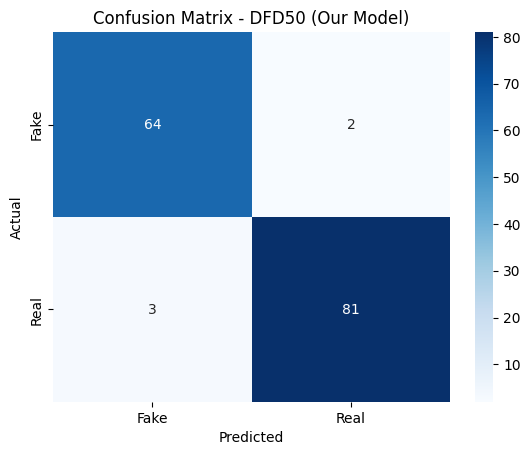

In [ ]:
print_evaluation_metrics(labels1, preds1, "DFD50 (Our Model)")


In [ ]:
import tensorflow as tf
import numpy as np
import cv2
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sn

# Load the TensorFlow Xception model
tf_model_path = "/content/drive/Shareddrives/deepfakedetect/deepfakedetect/xception_deepfake_image_5o.h5"  # Path to uploaded TensorFlow model
xception_tf_model = tf.keras.models.load_model(tf_model_path)
print("TensorFlow Xception model loaded successfully.")

# Preprocess a batch of frames for TensorFlow Xception model
def preprocess_tf_batch(frames, image_size=(224, 224)):
    processed_frames = []
    for frame in frames:
        if frame is None or frame.size == 0:
            continue  # Skip empty frames
        resized_frame = cv2.resize(frame, image_size)  # Resize frame
        processed_frame = tf.keras.applications.xception.preprocess_input(resized_frame)
        processed_frames.append(processed_frame)
    return np.array(processed_frames)


# Evaluate TensorFlow Xception Model
def evaluate_tf_model(model, data_loader):
    all_preds = []
    all_labels = []

    for inputs, labels in data_loader:
        # Check and convert PyTorch Tensors to Numpy arrays
        if isinstance(inputs, torch.Tensor):
            inputs = inputs.numpy()

        # Flatten the batch and sequence into individual frames
        batch_size, seq_length, c, h, w = inputs.shape
        frames = inputs.reshape(batch_size * seq_length, c, h, w)

        # Convert to channels-last (HWC) format
        frames = np.transpose(frames, (0, 2, 3, 1))  # Convert to (N, H, W, C)

        # Preprocess inputs for TensorFlow model
        processed_frames = preprocess_tf_batch(frames)

        # Predict using TensorFlow model
        predictions = model.predict(processed_frames, batch_size=32)

        # Adjust threshold
        predictions = (predictions >= 0.5).astype(int)

        # Aggregate predictions for video-level classification
        video_preds = predictions.reshape(batch_size, seq_length).mean(axis=1).round()

        # Append predictions and labels
        all_preds.extend(video_preds.tolist())
        all_labels.extend(labels.numpy().tolist())  # Convert labels to list

    return np.array(all_preds), np.array(all_labels)




# Evaluate TensorFlow Xception Model
preds_tf, labels_tf = evaluate_tf_model(xception_tf_model, test_loader)



TensorFlow Xception model loaded successfully.
2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 5s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
2/2 

Performance Metrics for TensorFlow Xception Model:
Performance Metrics for TensorFlow Xception Model
              precision    recall  f1-score   support

        Fake       0.48      0.82      0.60        66
        Real       0.68      0.30      0.41        84

    accuracy                           0.53       150
   macro avg       0.58      0.56      0.51       150
weighted avg       0.59      0.53      0.50       150



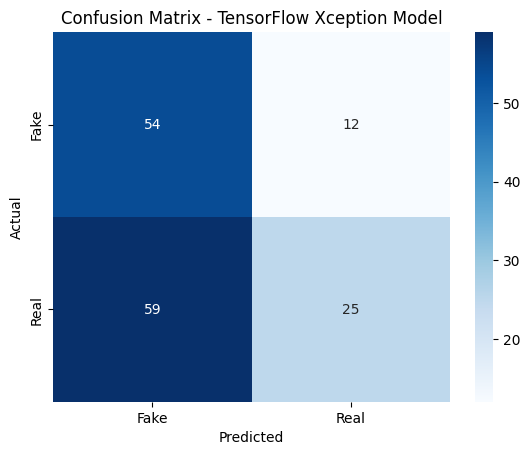

In [ ]:

# Compare Performance
print("Performance Metrics for TensorFlow Xception Model:")
print_evaluation_metrics(labels_tf, preds_tf, "TensorFlow Xception Model")